Load in our precomputed DINOV2 feature maps for CIRFAR10

In [1]:
from utils.config import Project_Config

MODEL_NAME = "sd1-cifar10-v2"      #"sd1-cifar10-v2"

project_config = Project_Config(
    IS_CUDA = True,
    IS_WINDOWS = False,
)

/home/joy/miniconda3/envs/SD3HF_Unstable/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/joy/miniconda3/envs/SD3HF_Unstable/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/home/joy/miniconda3/envs/SD3HF_Unstable/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_bwd")


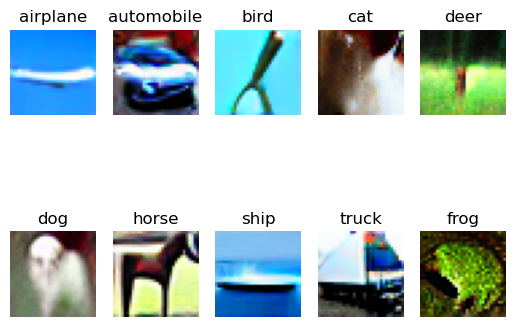

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import os
%matplotlib inline

prompts=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'horse', 'ship', 'truck', 'frog']
i = 0

generated_images = []

for prompt in prompts:
    seed = 1

    save_path = f"generated_images/{MODEL_NAME}/{str(seed)}/{prompt}/"
    assert(os.path.isdir(save_path))

    image = Image.open(save_path+prompt+".png")

    i=i+1
    plt.subplot(2, 5, i)
    plt.axis('off')
    plt.title(prompt)
    plt.imshow(image)
    generated_images.append(image)

In [3]:
import torch
dino_cifar10 = torch.load("dino_cifar10.pt")
print(list(dino_cifar10.shape))

dino_cifar10 = dino_cifar10.reshape(50000,257*768)

/tmp/ipykernel_324833/1745006164.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dino_cifar10 = torch.load("dino_cifar10.pt")


[50000, 257, 768]


Now generate attributions using cosine similarity on the DINOV2 feature maps

In [ ]:
from transformers import AutoImageProcessor, Dinov2Model


def calculate_DINO_Attribution(image, n):
    image_processor = AutoImageProcessor.from_pretrained("facebook/dinov2-base")

    model = Dinov2Model.from_pretrained("facebook/dinov2-base")

    input_image = image_processor(image, return_tensors="pt")

    if project_config.IS_CUDA:
        model.to("cuda")
        input_image.to("cuda")

    with torch.no_grad():
        outputs = model(**input_image)

    last_hidden_state = outputs.last_hidden_state

    last_hidden_state = last_hidden_state.reshape(1,257*768)

    if project_config.IS_CUDA:
        #We have to move this back to the CPU 
        # because the chances of dino_cifar10 (40GB ish)
        # fitting in VRAM is slim
        last_hidden_state = last_hidden_state.detach().cpu()

    cosine_similarity = torch.nn.CosineSimilarity(dim=1)

    c = torch.zeros(1,50000)

    set_size = 1000
    dataset_size = 50000

    for i in range(0,dataset_size//set_size):
        a=i*set_size
        b=(i+1)*set_size

        c[0,a:b] = cosine_similarity(last_hidden_state,dino_cifar10[a:b])

    top_k = torch.topk(c,n)
    top_k_scores = torch.flatten(top_k.values)
    top_k_indicies = torch.flatten(top_k.indices)
    return top_k_indicies, top_k_scores

In [ ]:
from datasets import load_dataset

#https://huggingface.co/datasets/

dataset_name = "uoft-cs/cifar10"
dataset = load_dataset(dataset_name, split="train")

dataset = dataset.rename_column("img", "image")

In [11]:
TOP_N_IMAGES_TO_SHOW = 5
top_n_indices = []
top_n_scores = []
for i in range(len(prompts)):
    top_n_i, top_n_s = calculate_DINO_Attribution(generated_images[i],TOP_N_IMAGES_TO_SHOW)
    top_n_indices.append(top_n_i)
    top_n_scores.append(top_n_s)

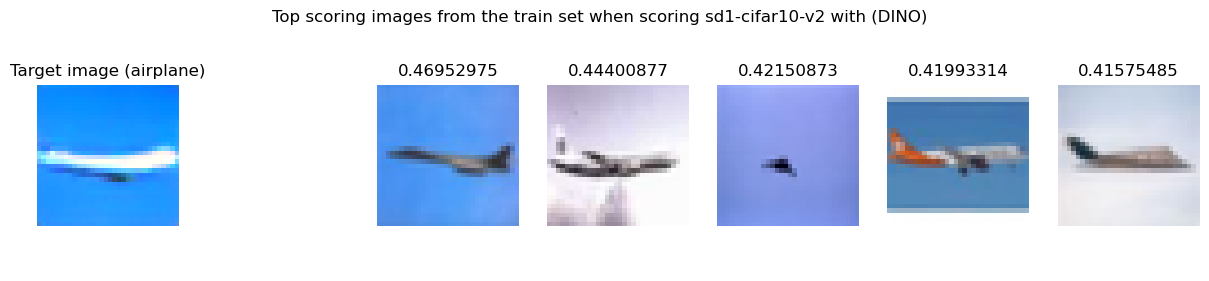

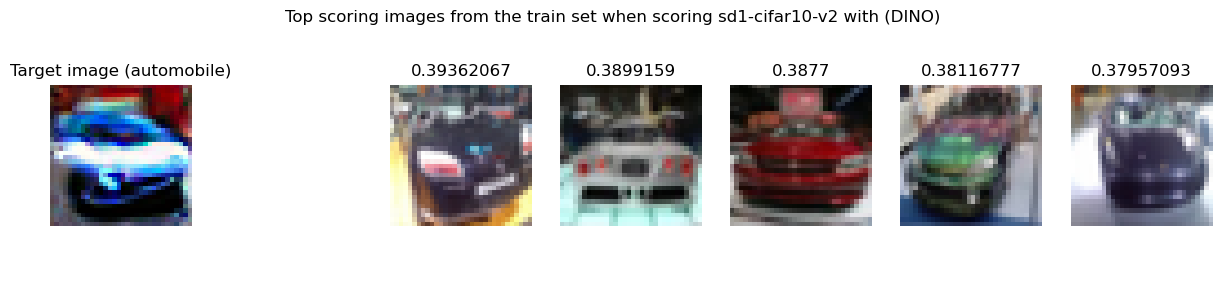

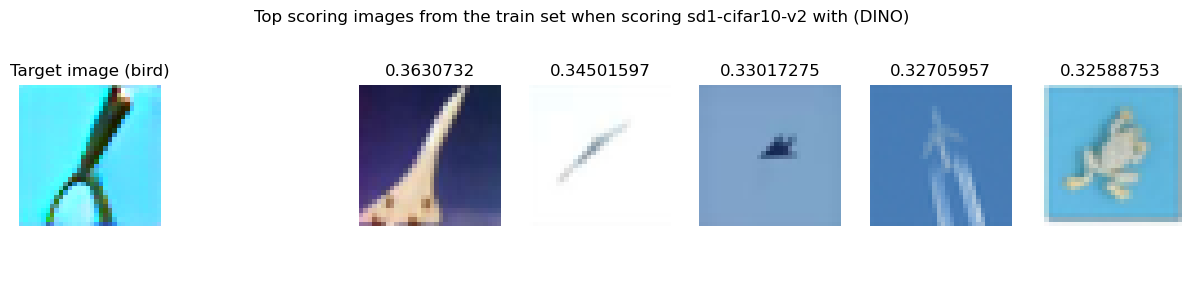

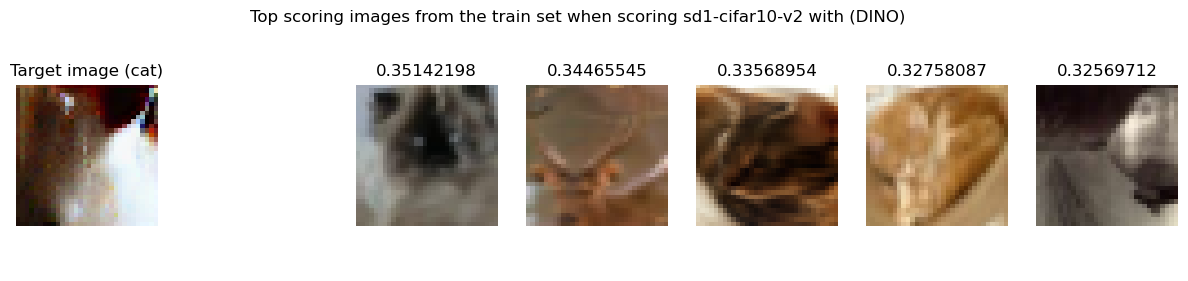

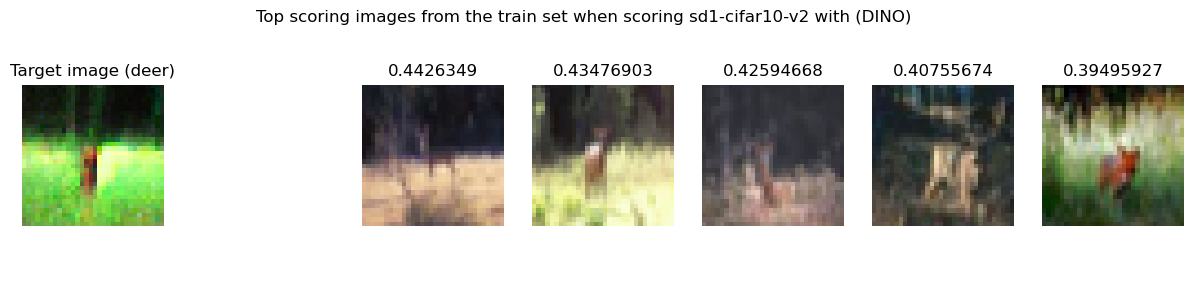

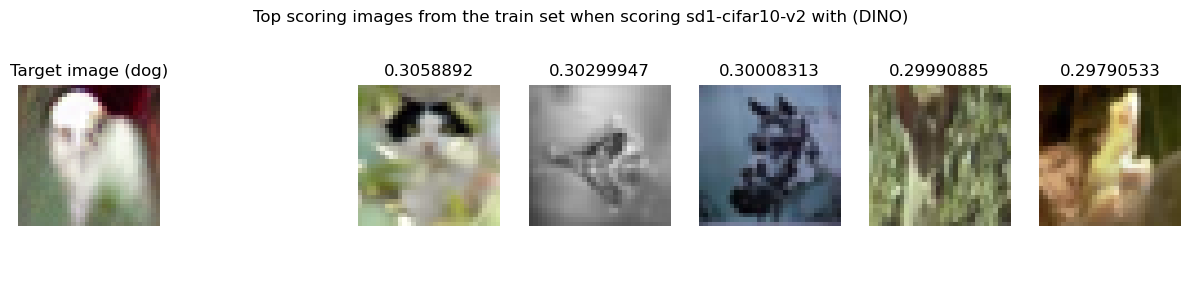

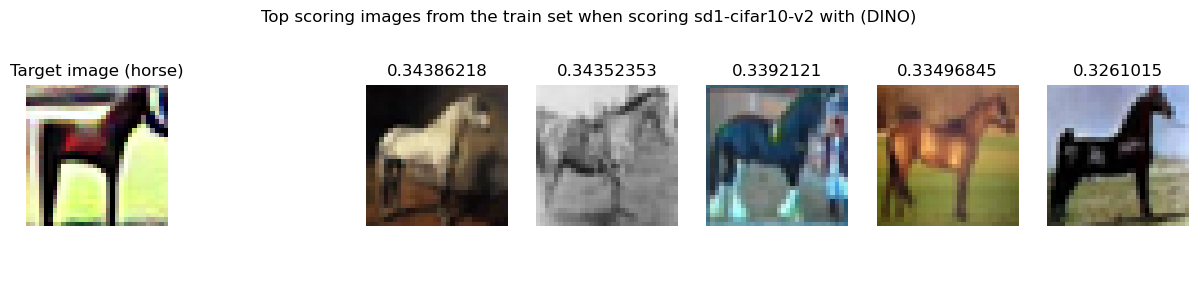

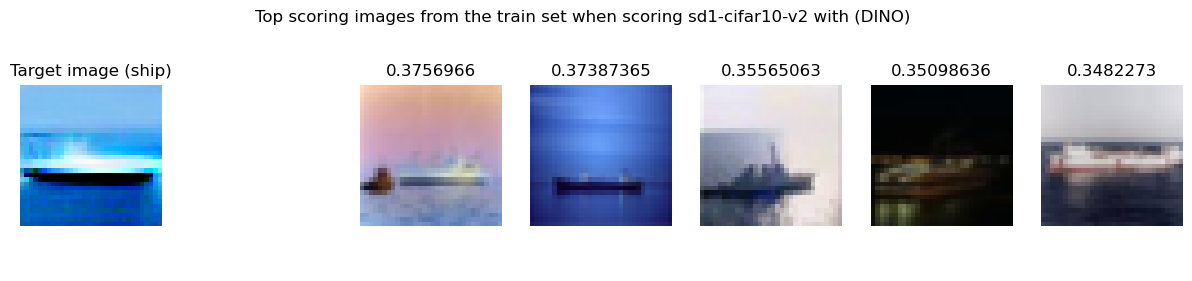

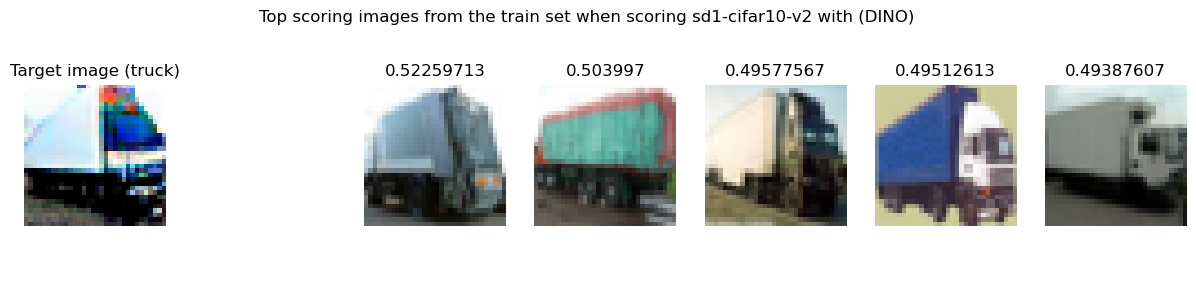

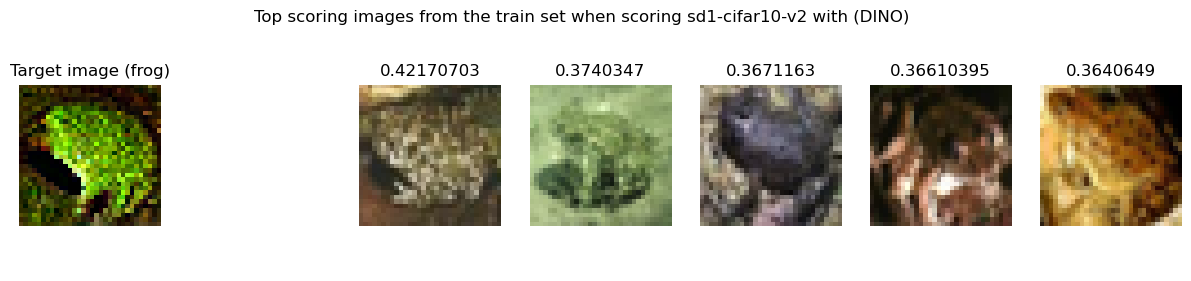

In [14]:

for i in range(len(prompts)):

    fig, axs = plt.subplots(ncols=7, figsize=(15, 3))
    fig.suptitle(f'Top scoring images from the train set when scoring {MODEL_NAME} with (DINO)')
    
    axs[0].imshow(generated_images[i])
    
    axs[0].axis('off')
    axs[0].set_title('Target image' + " (" + prompts[i] + ")")
    axs[1].axis('off')
    
    for j in range(len(top_n_indices[i])):
        axs[j + 2].imshow(dataset[int(top_n_indices[i][j])]["image"])
        axs[j + 2].axis('off')
        axs[j + 2].set_title(str(top_n_scores[i][j].numpy()))

    fig.show()